In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "cnnsuperbird/dataset_sb/"

In [4]:
sz=224

In [5]:
!ls {PATH}

models	tmp  train  valid


In [6]:
!ls {PATH}valid

bird  superman


In [7]:
files = !ls {PATH}valid/superman | head
files

['superman.45.jpg',
 'superman.46.jpg',
 'superman.47.jpg',
 'superman.48.jpg',
 'superman.49.jpg',
 'superman.50.jpg',
 'superman.51.jpg',
 'superman.52.jpg',
 'superman.53.jpg',
 'superman.54.jpg']

In [8]:
!ls {PATH}valid/bird | head

bird.100.jpg
bird.101.jpg
bird.102.jpg
bird.103.jpg
bird.104.jpg
bird.105.jpg
bird.106.jpg
bird.107.jpg
bird.108.jpg
bird.109.jpg


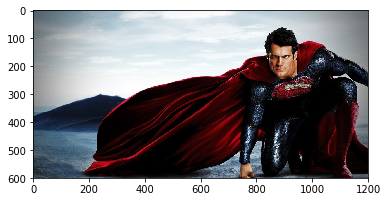

In [9]:
# https://matplotlib.org/users/image_tutorial.html
img = plt.imread(f'{PATH}valid/superman/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(600, 1200, 3)

In [11]:
img[:4,:4]

array([[[ 79,  96, 106],
        [ 80,  97, 107],
        [ 80,  97, 107],
        [ 80,  97, 107]],

       [[ 75,  92, 102],
        [ 76,  93, 103],
        [ 77,  94, 104],
        [ 79,  96, 106]],

       [[ 75,  92, 102],
        [ 75,  92, 102],
        [ 77,  94, 104],
        [ 78,  95, 105]],

       [[ 78,  95, 105],
        [ 79,  96, 106],
        [ 79,  96, 106],
        [ 79,  96, 106]]], dtype=uint8)

In [12]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [13]:
bs=5

In [14]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [15]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, bs, tfms)

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [22]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[   0.         0.51294  669.55872    0.91   ]              



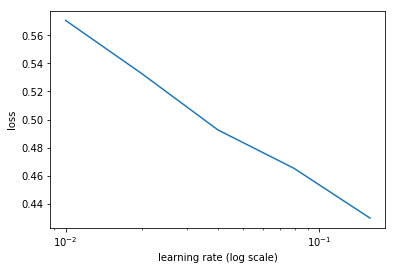

In [23]:
learn.sched.plot()

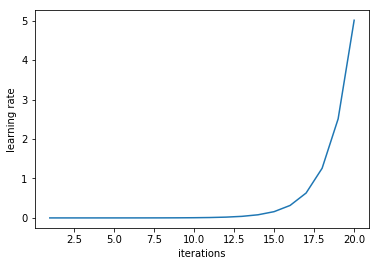

In [25]:
learn.sched.plot_lr()

In [26]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.34434  0.03409  0.99   ]                     
[ 1.       0.15373  0.03279  0.99   ]             
[ 2.       0.09719  0.02931  0.99   ]              
[ 3.       0.09749  0.03868  0.99   ]              



In [28]:
learn.unfreeze()

In [29]:
lr=np.array([0.0001,0.001,0.01])

In [32]:
learn.fit(lr,3,cycle_len=1,cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.2933   0.02067  0.99   ]                        
[ 1.       0.18966  0.0307   0.99   ]                      
[ 2.       0.16003  0.01245  1.     ]                      



In [33]:
learn.save('model')

In [34]:
learn.load('model')

In [35]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
# from here we know that 'bird' is label 0 and 'superman' is label 1.
data.classes

['bird', 'superman']

In [37]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(98, 2)

In [38]:
log_preds[:10]

array([[ -0.00007,  -9.62489],
       [ -0.     , -14.65797],
       [ -0.     , -14.65797],
       [ -0.00081,  -7.11866],
       [ -0.     , -12.51756],
       [ -0.00016,  -8.74246],
       [ -0.00002, -10.9724 ],
       [ -0.00004, -10.12247],
       [ -0.00191,  -6.26222],
       [ -0.00001, -11.22044]], dtype=float32)

In [39]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])   

In [40]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)

In [41]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [42]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [43]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


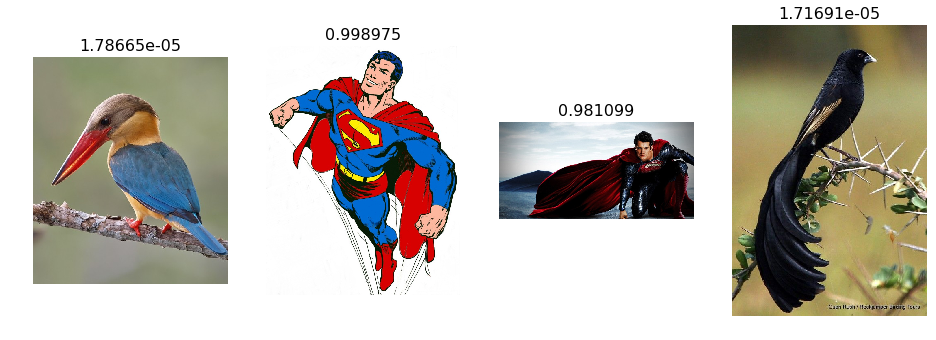

In [44]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [45]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: a must be non-empty

In [46]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct bird


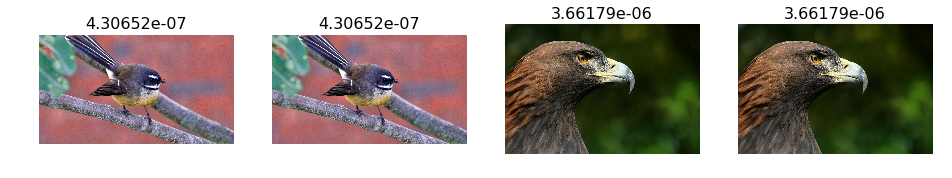

In [47]:
plot_val_with_title(most_by_correct(0, True), "Most correct bird")

Most correct superman


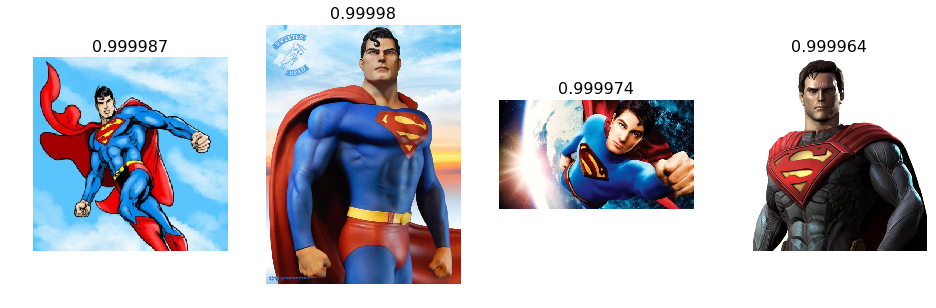

In [48]:
plot_val_with_title(most_by_correct(1, True), "Most correct superman")

In [163]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect bird")

Most incorrect bird


In [49]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect superman")

Most incorrect superman


Most uncertain predictions


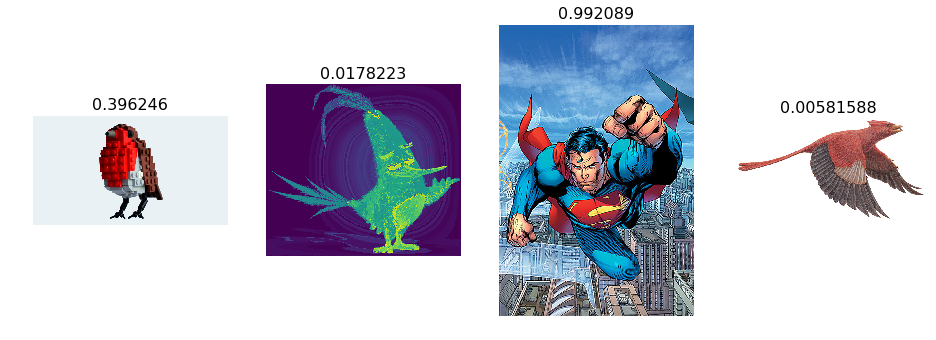

In [166]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")